In [3]:
# Quantum Machine Learning
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.algorithms import QAOA

# Classical Machine Learning
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

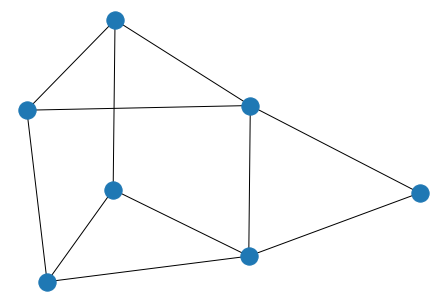

In [4]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
"""
# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()
"""
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

# Create an instance of a QAOA circuit given a graph.
#cost = qaoa_from_graph(graph=graphs[0], n_layers=1)



# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = torch.Variable([[0.5], [0.5]], dtype=torch.float32, requires_grad=True)
x=[0.5, 0.5]
#create_qaoa_circ(graphs[0],x)
G=graphs[0]
func=get_expectation(G, 1)
# Evaluate th QAOA instance just created with some angles.
print(func(x))

AttributeError: module 'torch' has no attribute 'Variable'

In [ ]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
#cell = tf.keras.layers.LSTMCell(2 * n_layers)
cell = torch.nn.LSTM(2,1,2)


# We create the QAOA MaxCut cost functions of some graphs
#graph_cost_list = [qaoa_from_graph(g) for g in graphs]
graph_cost_list = [get_expectation(g,1) for g in graphs]



In [6]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    # Concatenate the previous parameters and previous cost to create new input
    new_input = pytorch.cat([prev_cost, prev_params])
     # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])
   # Reshape the parameters to correctly match those expected by PennyLane
    _params = torch.reshape(new_params, shape=(2, n_layers))
                                      
    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    new_cost = torch.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]

    # Evaluate the cost using new angles
    #print(_params)
   # _params=_params.numpy().tolist()
    #_params=np.reshape(_params,(2,n_layers))
   # _params=np.reshape(_params,(2))
   # print(_params)
#    print(_cost)

def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = torch.zeros(shape=(1, 1))
    #need shape=?
    initial_params = torch.zeros(shape=(1, 2 * n_layers))
    initial_h = torch.zeros(shape=(1, 2 * n_layers))
    initial_c = torch.zeros(shape=(1, 2 * n_layers))

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = torch.mean(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    )
    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss
    
def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    # Evaluates the cost function
    loss = recurrent_loop(graph_cost)

    # Evaluates gradients, cell is the LSTM cell defined previously
    loss.backward()
    grads = cell.trainable_weights.grad

    # Apply gradients and update the weights of the LSTM cell
  #  opt.apply_gradients(zip(grads, cell.trainable_weights))
    optim = torch.optim.SGD(cell.trainable_weights.parameters(), lr=1e-2, momentum=0.9)

    return loss


In [43]:
# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)
[0. 0.]
-5.5517578125
tf.Tensor(
[[ 0.02485302]
 [-0.02292862]], shape=(2, 1), dtype=float32)
[ 0.02485302 -0.02292862]
-5.568359375
tf.Tensor(
[[ 0.04656834]
 [-0.03390301]], shape=(2, 1), dtype=float32)
[ 0.04656834 -0.03390301]
-5.5693359375
tf.Tensor(
[[ 0.06396838]
 [-0.03884038]], shape=(2, 1), dtype=float32)
[ 0.06396838 -0.03884038]
-5.595703125
tf.Tensor(
[[ 0.07646164]
 [-0.04063567]], shape=(2, 1), dtype=float32)
[ 0.07646164 -0.04063567]
-5.609375
loss
tf.Tensor([[-1.6765234]], shape=(1, 1), dtype=float32)
[<tf.Variable 'lstm_cell/kernel:0' shape=(3, 8) dtype=float32, numpy=
array([[ 0.24307436, -0.08713877, -0.21730691, -0.05246276, -0.6888292 ,
         0.27277917,  0.3546769 ,  0.550137  ],
       [-0.40424278, -0.40886533, -0.28007534,  0.32841176, -0.54181844,
         0.07099503,  0.11020452,  0.59037167],
       [-0.72457016,  0.03135979,  0.19873536, -0.4441215 ,  0.3388794 ,
         0.06770211, -0.57966

ValueError: No gradients provided for any variable: ['lstm_cell/kernel:0', 'lstm_cell/recurrent_kernel:0', 'lstm_cell/bias:0'].

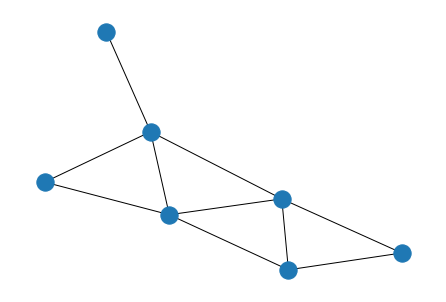

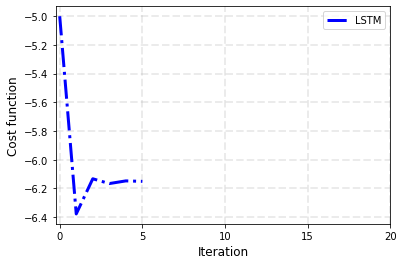

In [14]:
new_graph = nx.gnp_random_graph(7, p=3 / 7)
#new_cost = qaoa_from_graph(new_graph)
new_cost = get_expectation(new_graph,1)

nx.draw(new_graph)

# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()



Step 1 - Loss = -4.778125020606964
Step 2 - Loss = -5.021846710386333
Step 3 - Loss = -5.245049256345186
Step 4 - Loss = -5.444397183723359
Step 5 - Loss = -5.6177365085201005
Step 6 - Loss = -5.7643375879592975
Step 7 - Loss = -5.8851872093396445
Step 8 - Loss = -5.982827442720083
Step 9 - Loss = -6.060735253157997
Step 10 - Loss = -6.122592228411034
Step 11 - Loss = -6.171754459950065
Step 12 - Loss = -6.211009806300491
Step 13 - Loss = -6.242551089315066
Step 14 - Loss = -6.268057165753381
Step 15 - Loss = -6.2888034259865915
Final cost function: -6.30576281305346
Optimized angles: [[-0.40587313]
 [ 0.34315004]]


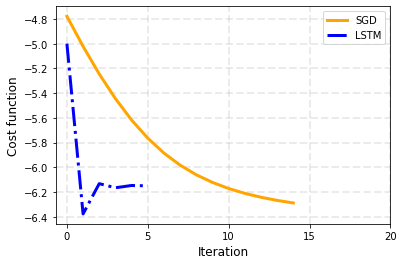

In [15]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    sdg_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()